<a href="https://colab.research.google.com/github/Sumner-Group/VelocityVerlet_vs_Euler/blob/main/Verlet_Euler_Diatomic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Illustrating the Velocity-Verlet & Euler Algorithms for Simulating Molecular Motion**

---

Ian Spurgeon and Isaiah Sumner

---

This is a Jupyter Notebook to illustrate the difference between the Velocity-Verlet and Euler methods for integrating classical equations of motion for a homonuclear diatomic molecule. The intention was to give chemistry undergraduate students a simple example of how computers can generate molecular trajectories, so that students could better understand how classical molecular dynamics (MD) works.

The Velocity-Verlet and Euler algorithms both attempt to predict the future position of an object ($x_{i+1}$) at some small point in the future, $\Delta$t (deltat), by using the object's current position ($x_i$), velocity ($v_i$), and acceleration ($a_i$). They then predict the future velocity of an object ($v_{i+1}$). It is important to remember Newton's second law of motion, which states that force on an object equals its mass times its acceleration: $F=m\bf{a}$ or $\bf{a}=\frac{F}{m}$.

---

**Euler Integration**
---

To calculate the future postion of an object, the Euler method uses the following equation: $x_{i+1}=x_i+v_i\Delta t+\frac{1}{2}a_i\Delta t^2$

or, using Newton's Second Law,

**Eq. (1)** $\space\space\space\bf{x_{i+1}=x_i+v_i\Delta t+\frac{1}{2}\frac{F_i}{m}\Delta t^2}$

To calculate the future velocity of an obect, the Euler method uses: $v_{i+1}=v_i+a_i\Delta t$

or,

**Eq. (2)**$\space\space\space\bf{v_{i+1}=v_i+\frac{F_i}{m}\Delta t}$

**Velocity-Verlet**
---

To calculate the future position of an object, the Velocity-Verlet algorithm is identical to the Euler algorithm:

**Eq. (3)**$\space\space\space\bf{x_{i+1}=x_i+v_i\Delta t+\frac{1}{2}\frac{F_i}{m}\Delta t^2}$

The calculation for the future velocity differs. It becomes, $v_{i+1}=v_i+\frac{1}{2}(a_i+a_{i+1})\Delta t$

or

**Eq. (4)**$\space\space\space\bf{v_{i+1}=v_i+\frac{1}{2}(\frac{F_i}{m}+\frac{F_{i+1}}{m})\Delta t}$

---
So, the difference between the two is on how they predict the future velocity. Euler just uses the current force ($F_i$), whereas Velocity-Verlet uses the current and *future* force ($F_{i+1}$). Using the future force is possible, because the force *only* depends on an object's position. Once we calculate the future postion, $x_{i+1}$, we should be able to calculate the future force.

---
In this notebook, we use a homonuclear diatomic molecule as an example. We assume no outside forces and assume that the bond connecting the molecule behaves like an ideal, Hooke's Law spring. Because we are modeling a diatomic molecule, the Euler and Velocity-Verlet Equations use reduced mass, $\bf{\mu}$, instead of mass $\bf{m}$.

**Eq. (5)**$\space\space\space\bf{\mu=\frac{m_1m_2}{m1+m2}}$,

where $\bf{m_1}$ and $\bf{m_2}$ are the masses of each of the nuclei. Because this notebook was designed for chemists, we use atomic mass units. Also, because this notebook was designed for chemists, we input the diatomic molecule's reduced mass vibrational frequency in cm$^{-1}$. This frequency is related to the Hooke's Law spring force constant, which is needed to calculate the force on the atoms. In the ensuing code, the calculated trajectories are compared to the exact trajectories. Students are encouraged to show how frequency, force and force constant are related. Students are also encouraged to derive the exact equations of motion.




In [ ]:
#@title **Integrate the Equations of Motion**
#@markdown *Both algorithms require initial positions and initial velocities of the atoms.*
#@markdown *To simplify matters, the code assumes that the inital velocity is 0 and*
#@markdown *the initial bond distance is the equilibrium bond distance plus 1 bohr (i.e. 0.529 Angstroms).*
#@markdown *In other words, we stretch the molecule a little and let it go!*
from mpl_toolkits.mplot3d.axes3d import axis3d
import math
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation',html='jshtml')
import numpy as np
from mpl_toolkits import mplot3d as plt3d
import matplotlib.animation as animation

pi=math.pi
time=[]
x_t=[]
v_t=[]
a_t=[]
x_t_exact=[]
error=[]
E=[]
def d(x,y):#returns derivative of a given point
  return y/x
def plotgraph(xarr,yarr,lx,ly):#     Takes two arrays and, using the first array's values as x coordinates
                              #     and the second one's for y coordinates, plots them, and then proceeding
  plt.plot(xarr,yarr)      #     to label the x axis as whatever 'lx' is and labels the y axis with the 'ly' argument
  plt.xlabel(lx)
  plt.ylabel(ly)
  return plt.plot

def avg(var1, var2):#Adds two numbers
  var_sum=((var1+var2))
  return var_sum/2
def pr(formula):#So I don't have to write out the whole word every time... We programmers are kind of lazy I guess
  print(formula)
def pw(b,e):#Me being lazy again...
  return math.pow(b,e)
def _2(base_number):#returns input number squared
  return (base_number*base_number)
def abs(var):#absolute value function
  var2=_2(var)
  return math.sqrt(var2)

# @markdown Choose Integration Algorithm:
equation="Euler" #@param ["Velocity-Verlet", "Euler"]
#@markdown Time step ($\Delta t$) in fs:
deltat=0.5#@param {type:"number"}
# @markdown Number of simulation steps
# @markdown   *Simulation length is (time step) x (number of steps) in fs
Length_Of_Run = 200#@param {type:"number"}
#@markdown The vibrational frequency ($\omega$) in cm$^{-1}$
omega = 2000#@param {type:"number"}
#@markdown The reduced mass of the diatomic ($\mu$) in a.m.u.
mu = 0.5#@param {type:"number"}
#@markdown Equilibrium Bond distance in Angstroms
r=1.0 #@param {type:"number"}

debugpr=0

#Unit conversions

au2fs = 0.002418843266 #Converts aomitc units to fs
amu2au = 1822.8885 #Converts amu to electron mass
wn2au = 7.2518152111*10**-7 #Converts wavenumbers to atomic units of frequency
eh2kcal = 627.509474 #Converts hartrees (E_h) to kcal/mol
bohr2ang = 0.5291772 #Converts bohrs to angstroms

deltaT=deltat/au2fs #Convert fs to atomic units
m=mu*amu2au
om=omega*wn2au
k=m*_2(om)


xt=1 #Starting X value
vt=0 #Starting velocity
at=-k/m #Starting acceleration
error1=0 #We start with no error
E1=(0.5*k*_2(xt)+.5*m*_2(vt))*eh2kcal #Total energy

x_t.append(xt) #Putting above values into respective arrays
v_t.append(vt)
a_t.append(at)
error.append(error1)
E.append(E1)

def eom(times): #Integrates the equations of motion (Main function)
  t1=1 #Creating an index for each variable
  xt1=0
  vt1=0
  at1=0
  xte1=1
  er1=0
  e1=0
  time.append(0)
  x_t_exact.append(1)
  o=0#placeholder for equation output
  for i in range(times-1):
    if equation=="Velocity-Verlet": #Velocity Verlet Integration
      o=t1*deltaT #T
      time.append(o)
      t1+=1

      o=math.cos(xte1*deltaT*om)# x(t) exact
      x_t_exact.append(o)
      xte1+=1

      o=x_t[len(x_t)-1]+v_t[len(x_t)-1]*deltaT+.5*a_t[len(x_t)-1]*_2(deltaT) #x(t)
      x_t.append(o)
      xt1+=1

      o=(-1*k*x_t[len(x_t)-1])/m #a(t)
      a_t.append(o)
      at1+=1

      o=v_t[len(v_t)-1]+.5*(a_t[len(a_t)-2]+a_t[len(a_t)-1])*deltaT #v(t)
      v_t.append(o)
      vt1+=1

      o=(.5*m*_2(v_t[len(v_t)-1])+.5*k*_2(x_t[len(x_t)-1]))*eh2kcal #Energy
      E.append(o)
      e1+=1

      o=abs(x_t_exact[len(x_t_exact)-1]-x_t[len(x_t)-1])#error
      error.append(o)
      er1+=1
    if equation=="Euler": #Euler integration
      o=t1*deltaT #T
      time.append(o)
      t1+=1

      o=math.cos(xte1*deltaT*om)# x(t) exact
      x_t_exact.append(o)
      xte1+=1

      o=x_t[len(x_t)-1]+v_t[len(x_t)-1]*deltaT+.5*a_t[len(x_t)-1]*_2(deltaT) #x(t)
      x_t.append(o)
      xt1+=1

      o=(-1*k*x_t[len(x_t)-1])/m #a(t)
      a_t.append(o)
      at1+=1

      o=v_t[vt1]+a_t[at1-1]*deltaT#v(t)
      v_t.append(o)
      vt1+=1

      o=(.5*m*_2(v_t[len(v_t)-1])+.5*k*_2(x_t[len(x_t)-1]))*eh2kcal #Energy
      E.append(o)
      e1+=1

      o=abs(x_t_exact[len(x_t_exact)-1]-x_t[len(x_t)-1])#error
      error.append(o)
      er1+=1
if debugpr>0:
  pr("Delta T/Pi")    #this section prints arrays and their titles
  pr(deltat)
  pr("T")
  pr(time)
  pr("x(t)")
  pr(x_t)
  pr("v(t)")
  pr(v_t)
  pr("a(t)")
  pr(a_t)
  pr("x(t) exact")
  pr(x_t_exact)
  pr("error")
  pr(error)
p=0

eom(Length_Of_Run)#executes main  function




In [ ]:
#@title **Animate**
%matplotlib agg
#@markdown *This section of code will display an animation of a vibrating molecule based on the equations of motion you integrated. The circles are the atoms.*

#@markdown Number of Animation frames shown per second in animation:

#@markdown *Note: the human eye will start to see motion somewhere between 30-60 fps
fps=60 #@param {type:"number"}
intrvl=1000/fps#this takes desired fps and converts it to millisecond delay between frames
#@markdown How much delay before the animation repeats, in milliseconds
r_d=1000#@param {type:"number"}
#@markdown This changes how big objects shown in animation are, in typographic points(1 point=1/72 in)
object_radius = 100 #@param {type:"slider", min:30, max:200, step:1}
#@markdown Color of objects shown in animation(r for red, g for green, b for blue)
object_color= "b" #@param ["r","g","b"]
ballvar=object_color+"o" #takes color and formats it into a marker style, by adding the o it makes a circle colored according to object_color
#@markdown Number of animation frames to run

#@markdown *Note: number of frames can't be more than Length of run
nframes=200 #@param {type:"number"}
if nframes>Length_Of_Run:
  pr("Warning: number of animation frames cannot be larger than length of run. defaulting to length of run")
  nframes=Length_Of_Run

startx=x_t[0]*bohr2ang+r
lenx=0.5*startx+0.5
fig=plt.figure()
ax=plt.axes(title="Vibrating Molecule",xlabel="Atomic Positions (Angstroms)",xlim=(-lenx,lenx),ylim=(-.5,.5))

def frame(w):#for x(t)
  global ax1
  global p
  global object_radius
  global object_color
  global r
  if not p>=w:

    if p==0:#first frame

      global x1,x2,y,d
      d=x_t[p]*bohr2ang+r
      x1=0-.5*d
      x2=0+.5*d
      x=[x1,x2]
      y=[0,0] #I fixed y, as the y does not change
    elif p%2==0:#any subsequent even frame index
      d=x_t[p]*bohr2ang+r
      x1=0-.5*d
      x2=0+.5*d
      x=[x1,x2]
      y=[0,0]
    elif p%2==1:#any subsequent odd frame index
      d=x_t[p]*bohr2ang+r
      x1=0-.5*d
      x2=0+.5*d
      y=[0,0]
      x=[x1,x2]
    ax.clear()
    plt.title("Vibrating Molecule")
    ax.set_xlim(-lenx,lenx)
    ax.set_ylim(-.5,.5)
    plt.xlabel("Atomic Positions (Angstroms)")
    ax.scatter(x,y,s=object_radius,c=object_color)
    p+=1

anim = animation.FuncAnimation(fig, frame, frames=nframes, blit=False, repeat=True,repeat_delay=r_d,interval=intrvl)

anim

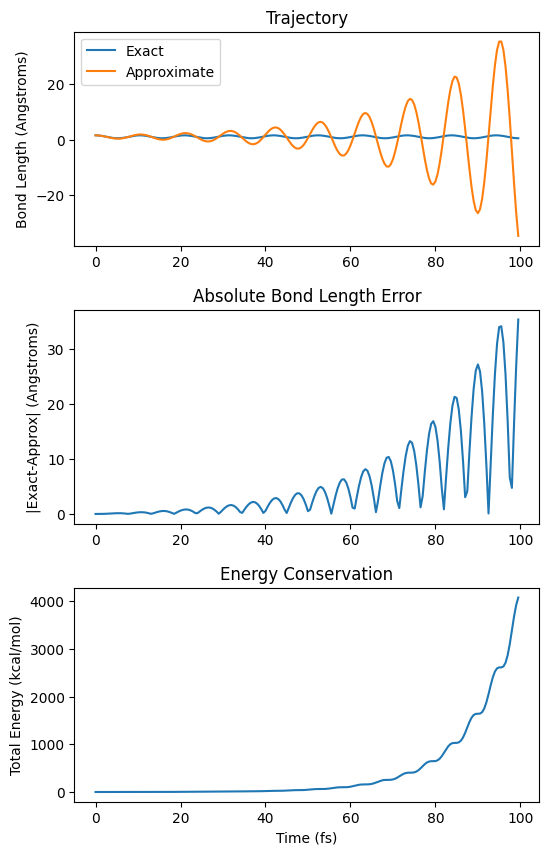

In [ ]:
#@title **Generate Plots**
#@markdown *This code will generate three plots. The first overlays the Exact trajectory*
#@markdown *and the Approximate trajectory based on your integration method.*
#@markdown *The second plot shows that absolute difference between the Exact trajctory and the Approximate trajectory.*
#@markdown *The final plot shows how the energy of the molecule changes over time.*
plt.close()
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

#plots information. For trajectory graph, x(t) exact is in blue, and x(t) in yellow
#Convert time to fs and position to Angstrom
time_fs = np.asarray(time)*au2fs
x_t_exact_ang=np.asarray(x_t_exact)*bohr2ang+r
x_t_ang = np.asarray(x_t)*bohr2ang+r
error_ang=np.asarray(error)*bohr2ang

fig = plt.figure(figsize=(6,10))
axs = fig.subplots(3)
axs[0].plot(time_fs, x_t_exact_ang,label="Exact")
axs[0].plot(time_fs, x_t_ang,label="Approximate")
axs[0].legend(loc="upper left")
axs[0].set_title("Trajectory")
axs[0].set_ylabel("Bond Length (Angstroms)")
axs[1].set_title("Absolute Bond Length Error")
axs[1].set_ylabel("|Exact-Approx| (Angstroms)")
axs[1].plot(time_fs,error_ang)
#axs[1].sharex(axs[0, 0])
axs[2].plot(time_fs, E)
axs[2].set_title("Energy Conservation")
axs[2].set_ylabel("Total Energy (kcal/mol)")
plt.xlabel("Time (fs)")
fig.subplots_adjust(hspace=0.3)
plt.show()

